In [1]:
'''from google.colab import drive
drive.mount('/content/drive')

import zipfile

zip_path = '/content/drive/MyDrive/trafic_32.zip'
extract_path = '/content/trafic_32'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)'''

"from google.colab import drive\ndrive.mount('/content/drive')\n\nimport zipfile\n\nzip_path = '/content/drive/MyDrive/trafic_32.zip'\nextract_path = '/content/trafic_32'\n\nwith zipfile.ZipFile(zip_path, 'r') as zip_ref:\n    zip_ref.extractall(extract_path)"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [4]:
image_size = 32
data_dir = './trafic_32/'
batch_size = 64
val_split = 0.1

In [5]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print(dataset.class_to_idx)

total_size = len(dataset)
val_size = int(total_size * val_split)
train_size = total_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Loadery
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

{'00000': 0, '00001': 1, '00002': 2, '00003': 3, '00004': 4, '00005': 5, '00006': 6, '00007': 7, '00008': 8, '00009': 9, '00010': 10, '00011': 11, '00012': 12, '00013': 13, '00014': 14, '00015': 15, '00016': 16, '00017': 17, '00018': 18, '00019': 19, '00020': 20, '00021': 21, '00022': 22, '00023': 23, '00024': 24, '00025': 25, '00026': 26, '00027': 27, '00028': 28, '00029': 29, '00030': 30, '00031': 31, '00032': 32, '00033': 33, '00034': 34, '00035': 35, '00036': 36, '00037': 37, '00038': 38, '00039': 39, '00040': 40, '00041': 41, '00042': 42}


In [6]:
print(dataset[1])
print(dataset[0][0].shape)

(tensor([[[-0.4275, -0.3804, -0.4039,  ..., -0.4353, -0.3882, -0.4824],
         [-0.5294, -0.4588, -0.3176,  ..., -0.3176, -0.4118, -0.4275],
         [-0.5451, -0.4588, -0.3176,  ..., -0.1843, -0.3647, -0.4667],
         ...,
         [ 0.2314,  0.2235,  0.0902,  ..., -0.3804, -0.3333, -0.2314],
         [-0.1373, -0.1608, -0.1765,  ..., -0.4039, -0.2706, -0.2000],
         [-0.4275, -0.3412, -0.2157,  ..., -0.4510, -0.2627, -0.2471]],

        [[-0.4196, -0.3725, -0.4196,  ..., -0.4275, -0.3725, -0.4667],
         [-0.4824, -0.4431, -0.3255,  ..., -0.3569, -0.4275, -0.4275],
         [-0.4431, -0.3961, -0.3490,  ..., -0.3412, -0.4510, -0.5137],
         ...,
         [ 0.0118,  0.0667,  0.0431,  ..., -0.3647, -0.3647, -0.2784],
         [-0.2157, -0.2392, -0.2706,  ..., -0.3255, -0.2157, -0.1373],
         [-0.4275, -0.3725, -0.3333,  ..., -0.3647, -0.1529, -0.1373]],

        [[-0.4039, -0.3569, -0.3961,  ..., -0.3882, -0.3804, -0.4902],
         [-0.4980, -0.4667, -0.3412,  ..., -

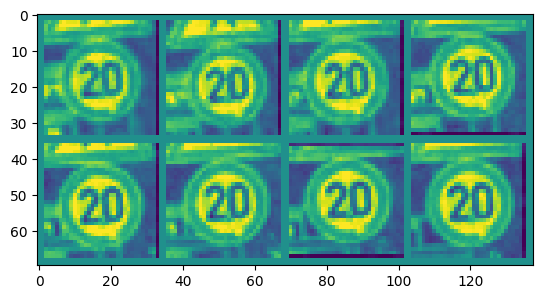

In [7]:
def get_train_images(num):
    return torch.stack([dataset[i][0] for i in range(10,10+num)], dim=0)

plt.imshow(torchvision.utils.make_grid(get_train_images(8), nrow=4)[0]);

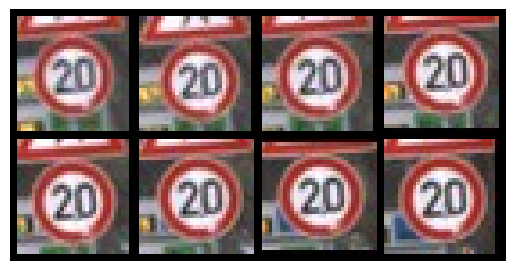

In [8]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def get_train_images(num):
    # Pobierz obrazy z datasetu
    images = torch.stack([dataset[i][0] for i in range(10, 10 + num)], dim=0)
    # Odwróć normalizację: (x * std) + mean
    images = images * 0.5 + 0.5  # dla mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
    return images

# Pobierz obrazy
images = get_train_images(8)

# Utwórz siatkę obrazów
grid = vutils.make_grid(images, nrow=4, padding=2, normalize=False)

# Zamień osie z (C, H, W) na (H, W, C) dla matplotlib
grid = grid.permute(1, 2, 0)

# Wyświetl obrazy
plt.imshow(grid)
plt.axis('off')
plt.show()

In [9]:
def corrupt(x, amount):
    noise = torch.randn_like(x)  # Gaussian noise
    amount = amount.view(-1, 1, 1, 1)
    # Blend original and noise, keeping range compatible with [-1, 1]
    noisy_x = x * (1 - amount) + noise * amount
    return noisy_x.clamp(-1, 1)  # Ensure output stays in [-1, 1]

Input shape: torch.Size([43, 3, 32, 32])


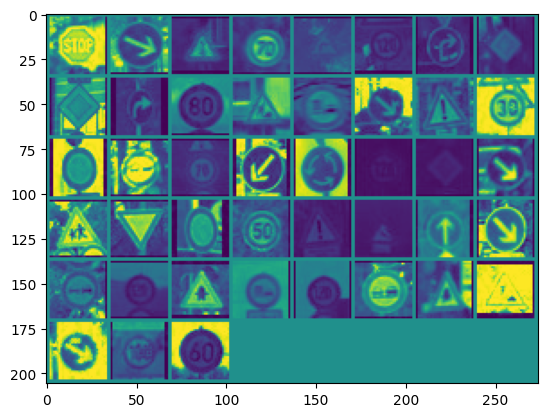

In [10]:
x, y = next(iter(train_loader))
x = x[:43]
print('Input shape:', x.shape)
plt.imshow(torchvision.utils.make_grid(x)[0]);

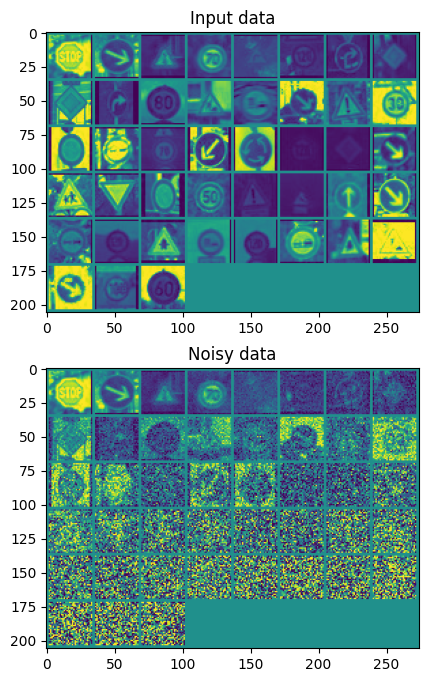

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0])

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

axs[1].set_title('Noisy data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0]);

In [12]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]  # [B, D/2]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)  # [B, D]
        return emb

In [13]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_classes=43, emb_dim=128):
        super().__init__()
        self.time_embedding = nn.Sequential(
            SinusoidalPosEmb(emb_dim),
            nn.Linear(emb_dim, emb_dim * 2),
            nn.SiLU(),
            nn.Linear(emb_dim * 2, emb_dim)
        )
        self.class_embedding = nn.Embedding(num_classes, emb_dim)
        self.cond_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim)
        )

        # Definiujemy warstwy down_layers z BatchNorm2d
        self.down_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.BatchNorm2d(32),  # BatchNorm po Conv2d
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.BatchNorm2d(64),
            ),
            nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=5, padding=2),
                nn.BatchNorm2d(128),
            ),
            nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=5, padding=2),
                nn.BatchNorm2d(128),
            ),
        ])

        # Definiujemy warstwy up_layers z BatchNorm2d
        self.up_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(128 + emb_dim, 128, kernel_size=5, padding=2),
                nn.BatchNorm2d(128),
            ),
            nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=5, padding=2),
                nn.BatchNorm2d(64),
            ),
            nn.Sequential(
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.BatchNorm2d(32),
            ),
            nn.Sequential(
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
                nn.BatchNorm2d(out_channels),  # BatchNorm w ostatniej warstwie (opcjonalne)
            ),
        ])

        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x, y, t):
        t_emb = self.time_embedding(t)
        y_emb = self.class_embedding(y)
        cond_emb = self.cond_proj(t_emb + y_emb)

        h = []
        for i, l in enumerate(self.down_layers):
            x = l(x)  # Conv2d + BatchNorm2d
            x = self.act(x)  # Aktywacja po BatchNorm
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        cond = cond_emb[:, :, None, None].expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, cond], dim=1)

        for i, l in enumerate(self.up_layers):
            if i > 1:
                x = self.upscale(x)
                x += h.pop()
            x = l(x)  # Conv2d + BatchNorm2d
            x = self.act(x)  # Aktywacja po BatchNorm
        return x

In [14]:
net = BasicUNet().to(device)
net

BasicUNet(
  (time_embedding): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): SiLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
  )
  (class_embedding): Embedding(43, 128)
  (cond_proj): Sequential(
    (0): SiLU()
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(


In [15]:
def tensor_to_image(tensor, normalize=True):
    tensor = tensor.cpu().detach()
    print(f"Tensor min: {tensor.min().item():.4f}, max: {tensor.max().item():.4f}")
    if normalize:
        tensor = (tensor + 1) / 2
        tensor = tensor.clamp(0, 1)
    tensor = tensor.permute(1, 2, 0)
    return tensor.numpy()

In [16]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.14it/s]


Finished epoch 0. Average loss for this epoch: 0.292618
Sample 1:
Tensor min: -1.0000, max: -0.1765
Tensor min: -1.0000, max: 0.2649
Tensor min: -0.2455, max: 0.1635
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2760, max: 1.5776
Sample 3:
Tensor min: -1.0000, max: 0.7882
Tensor min: -1.0000, max: 0.8816
Tensor min: -0.2515, max: 1.1295


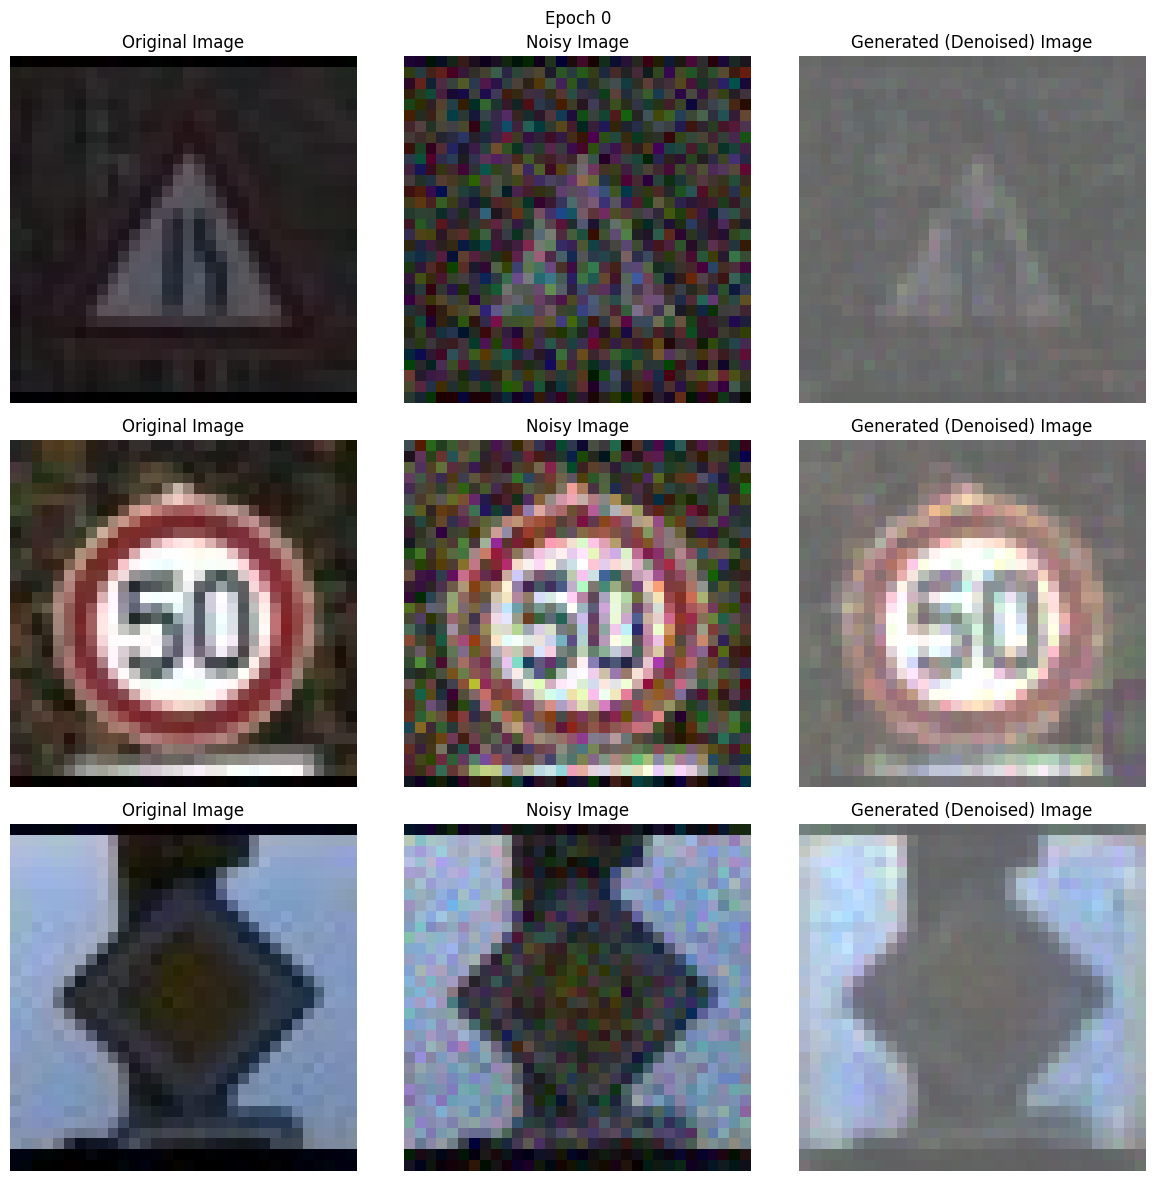

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.56it/s]


Finished epoch 1. Average loss for this epoch: 0.248784
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2650, max: 1.8009
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2622, max: 1.7613
Sample 3:
Tensor min: -1.0000, max: 0.4431
Tensor min: -1.0000, max: 0.4393
Tensor min: -0.2620, max: 0.5482


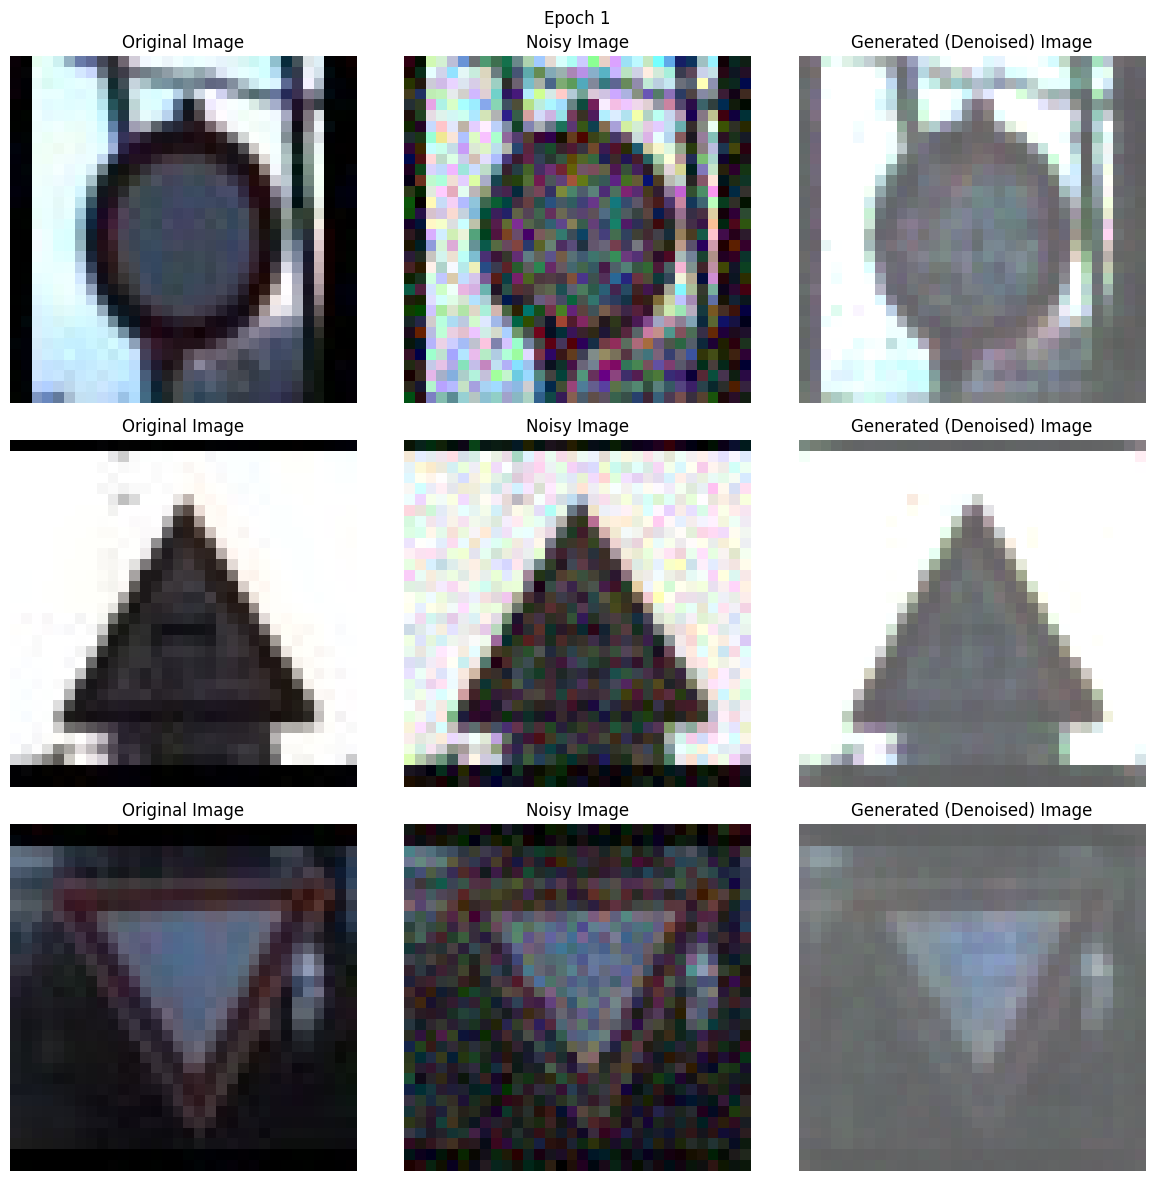

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.40it/s]


Finished epoch 2. Average loss for this epoch: 0.229334
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2648, max: 1.3749
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2592, max: 1.3905
Sample 3:
Tensor min: -1.0000, max: -0.2627
Tensor min: -1.0000, max: -0.0069
Tensor min: -0.2577, max: 0.0258


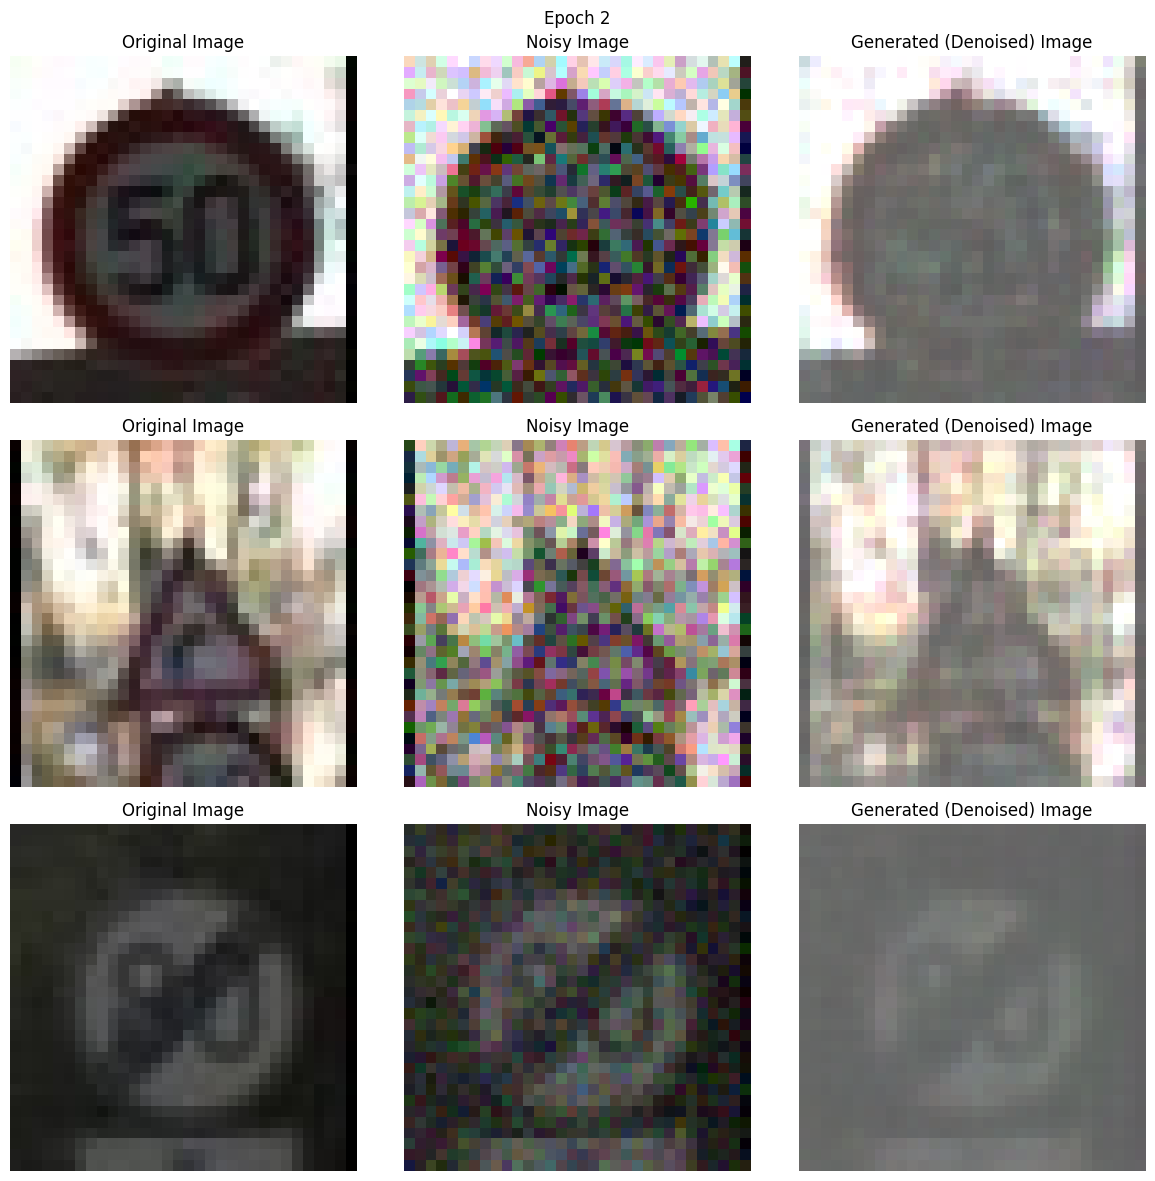

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.43it/s]


Finished epoch 3. Average loss for this epoch: 0.215802
Sample 1:
Tensor min: -0.9529, max: -0.4745
Tensor min: -1.0000, max: -0.2130
Tensor min: -0.2640, max: -0.0819
Sample 2:
Tensor min: -1.0000, max: 0.9922
Tensor min: -1.0000, max: 0.9750
Tensor min: -0.2718, max: 1.1353
Sample 3:
Tensor min: -0.9922, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2714, max: 1.4565


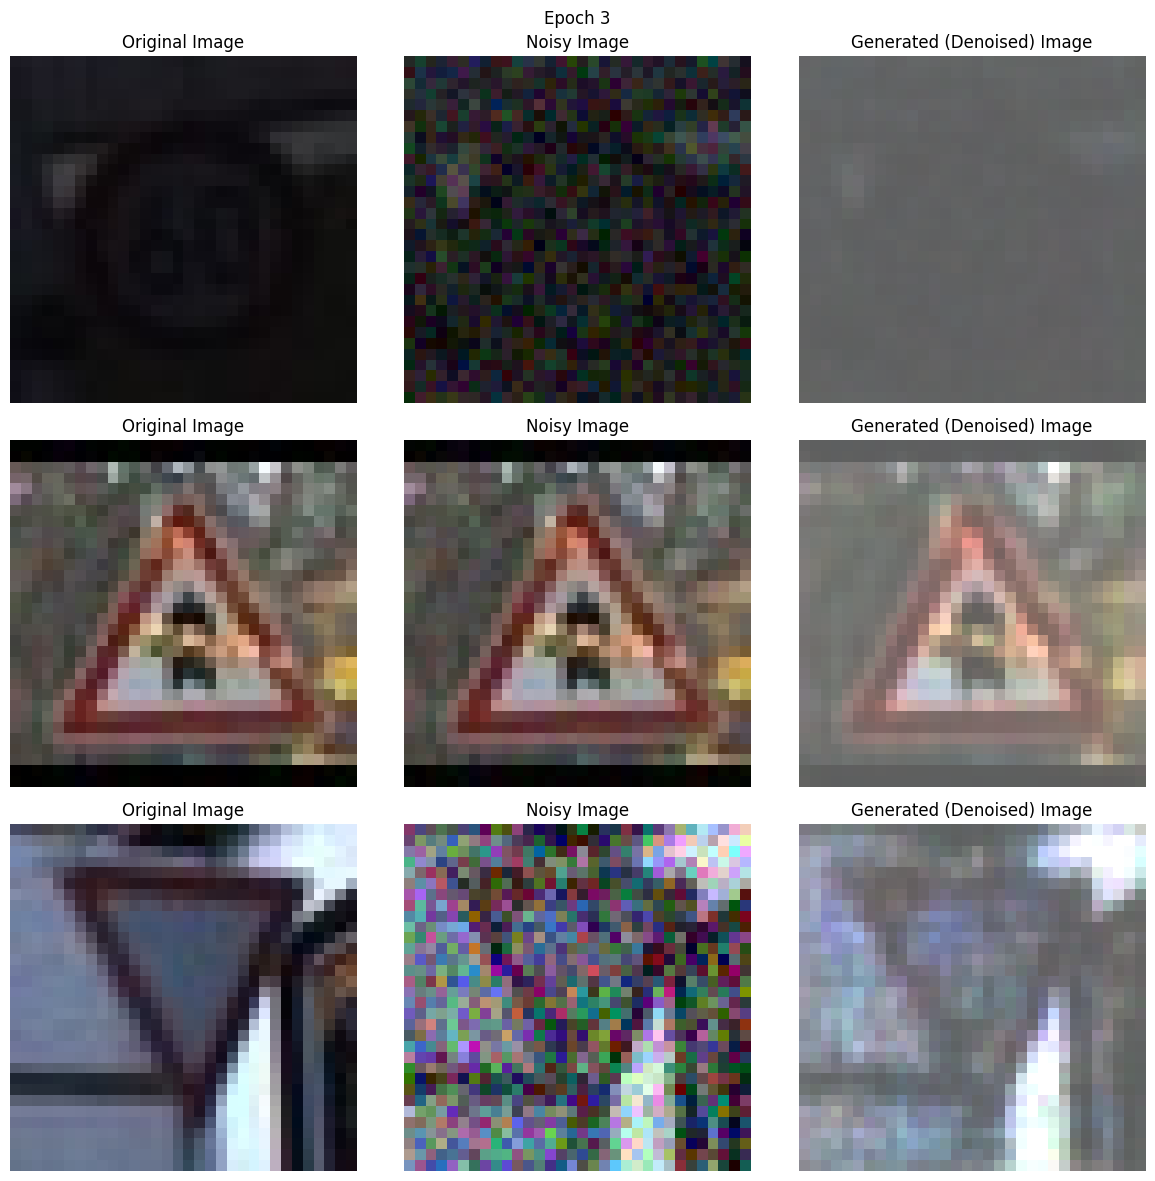

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.44it/s]


Finished epoch 4. Average loss for this epoch: 0.204107
Sample 1:
Tensor min: -1.0000, max: 0.5137
Tensor min: -1.0000, max: 0.5169
Tensor min: -0.2780, max: 0.6557
Sample 2:
Tensor min: -1.0000, max: 0.8824
Tensor min: -1.0000, max: 0.8677
Tensor min: -0.2784, max: 1.1364
Sample 3:
Tensor min: -0.9059, max: 1.0000
Tensor min: -0.9372, max: 1.0000
Tensor min: -0.2775, max: 1.5330


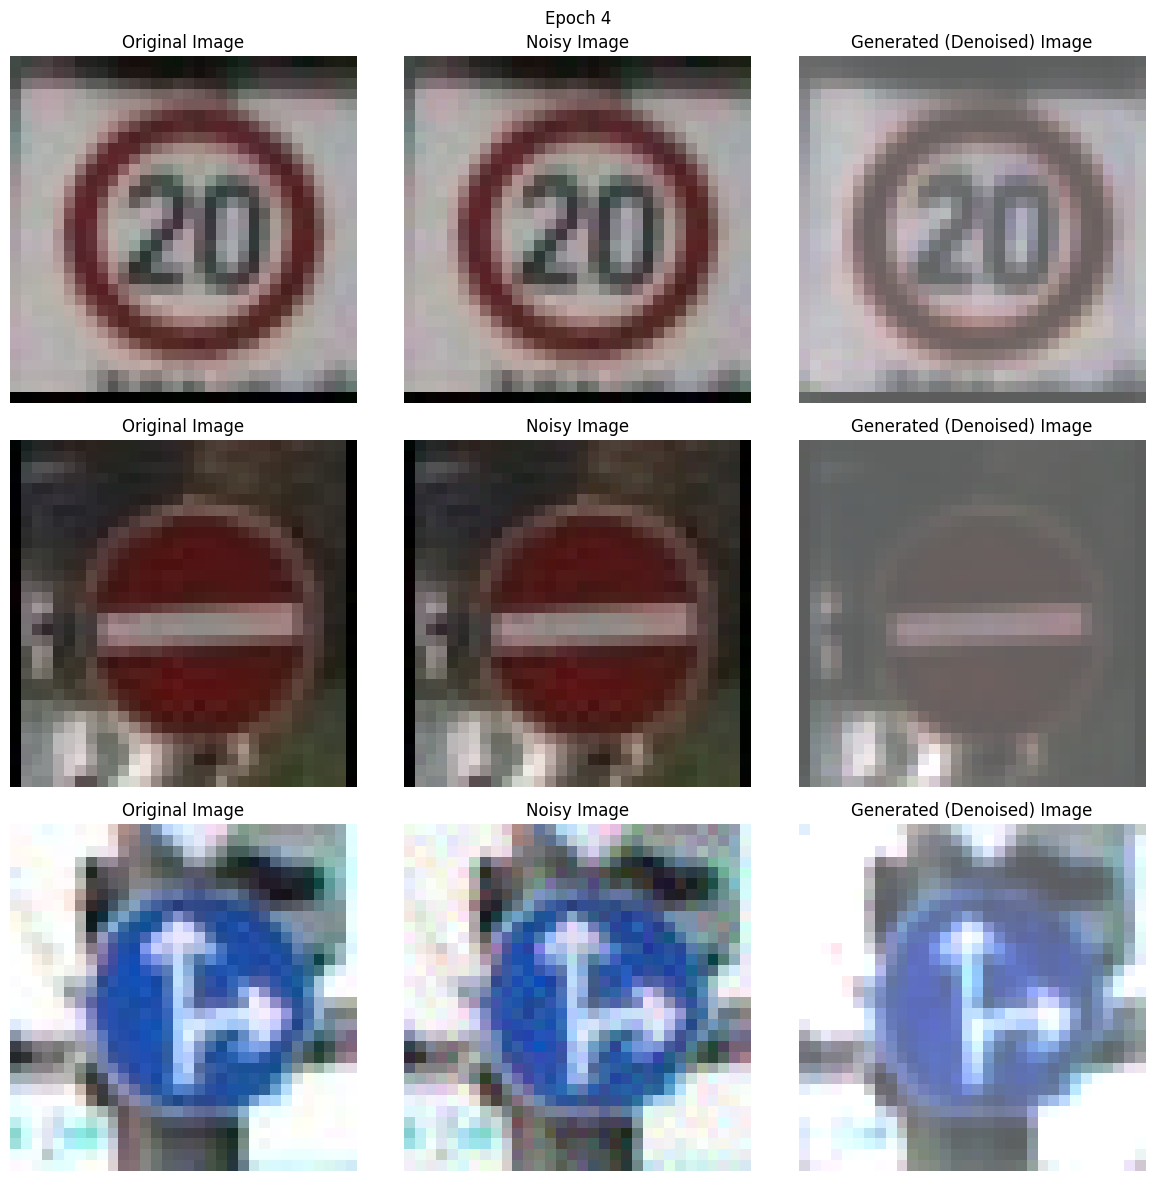

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.49it/s]


Finished epoch 5. Average loss for this epoch: 0.194756
Sample 1:
Tensor min: -1.0000, max: -0.4431
Tensor min: -1.0000, max: 0.5036
Tensor min: -0.2785, max: -0.0000
Sample 2:
Tensor min: -1.0000, max: -0.5451
Tensor min: -1.0000, max: 0.1893
Tensor min: -0.2763, max: -0.2001
Sample 3:
Tensor min: -1.0000, max: -0.4510
Tensor min: -1.0000, max: 0.0526
Tensor min: -0.2747, max: -0.1668


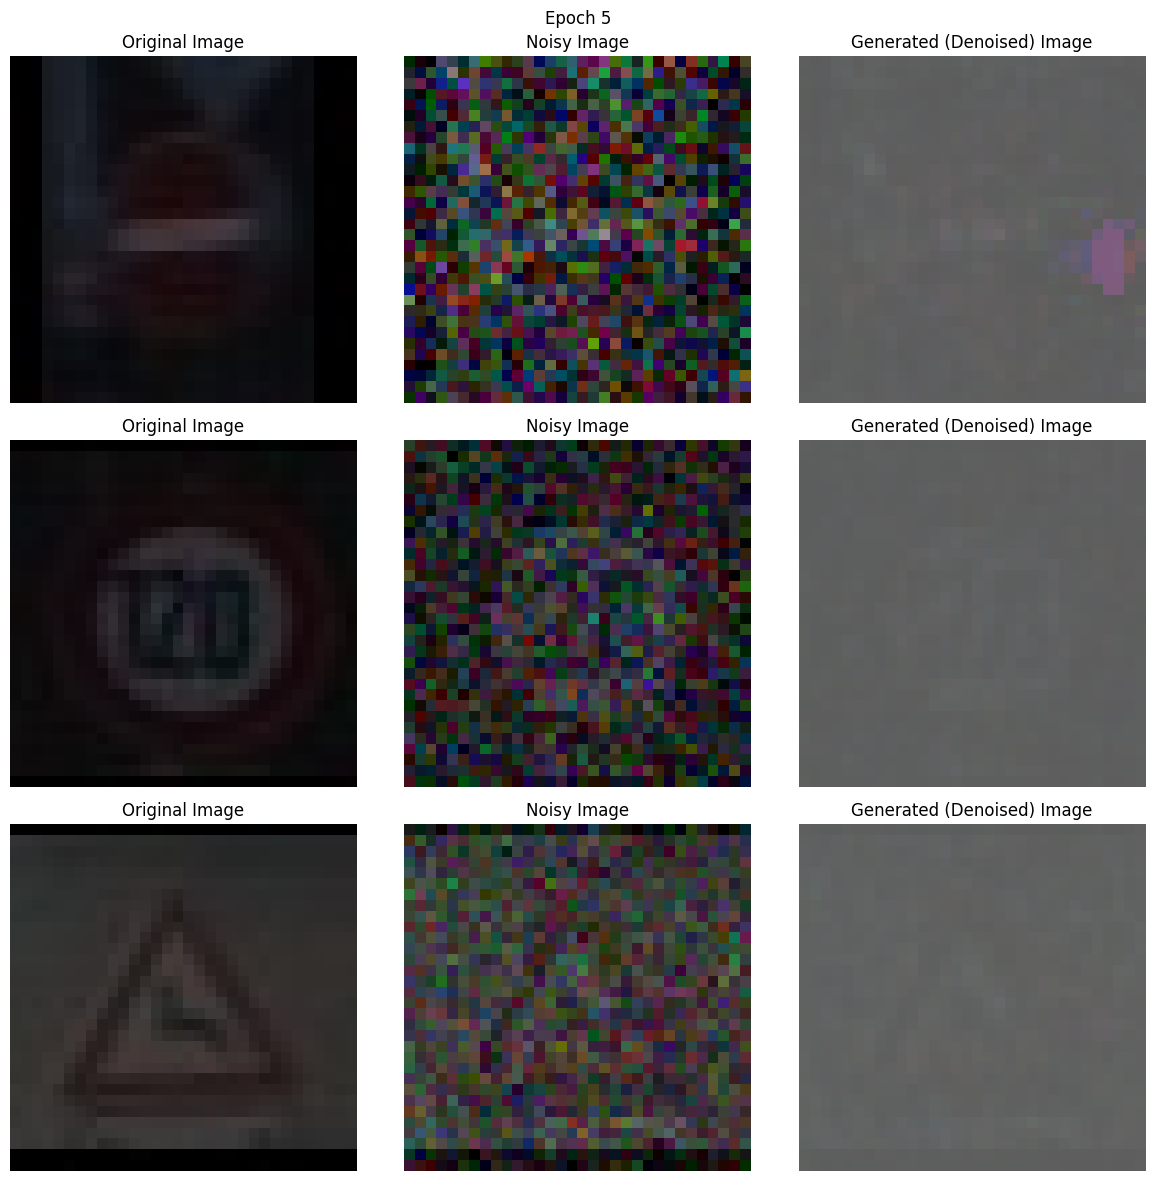

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.44it/s]


Finished epoch 6. Average loss for this epoch: 0.186916
Sample 1:
Tensor min: -1.0000, max: 0.9373
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2784, max: 1.2701
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.6351
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.4711


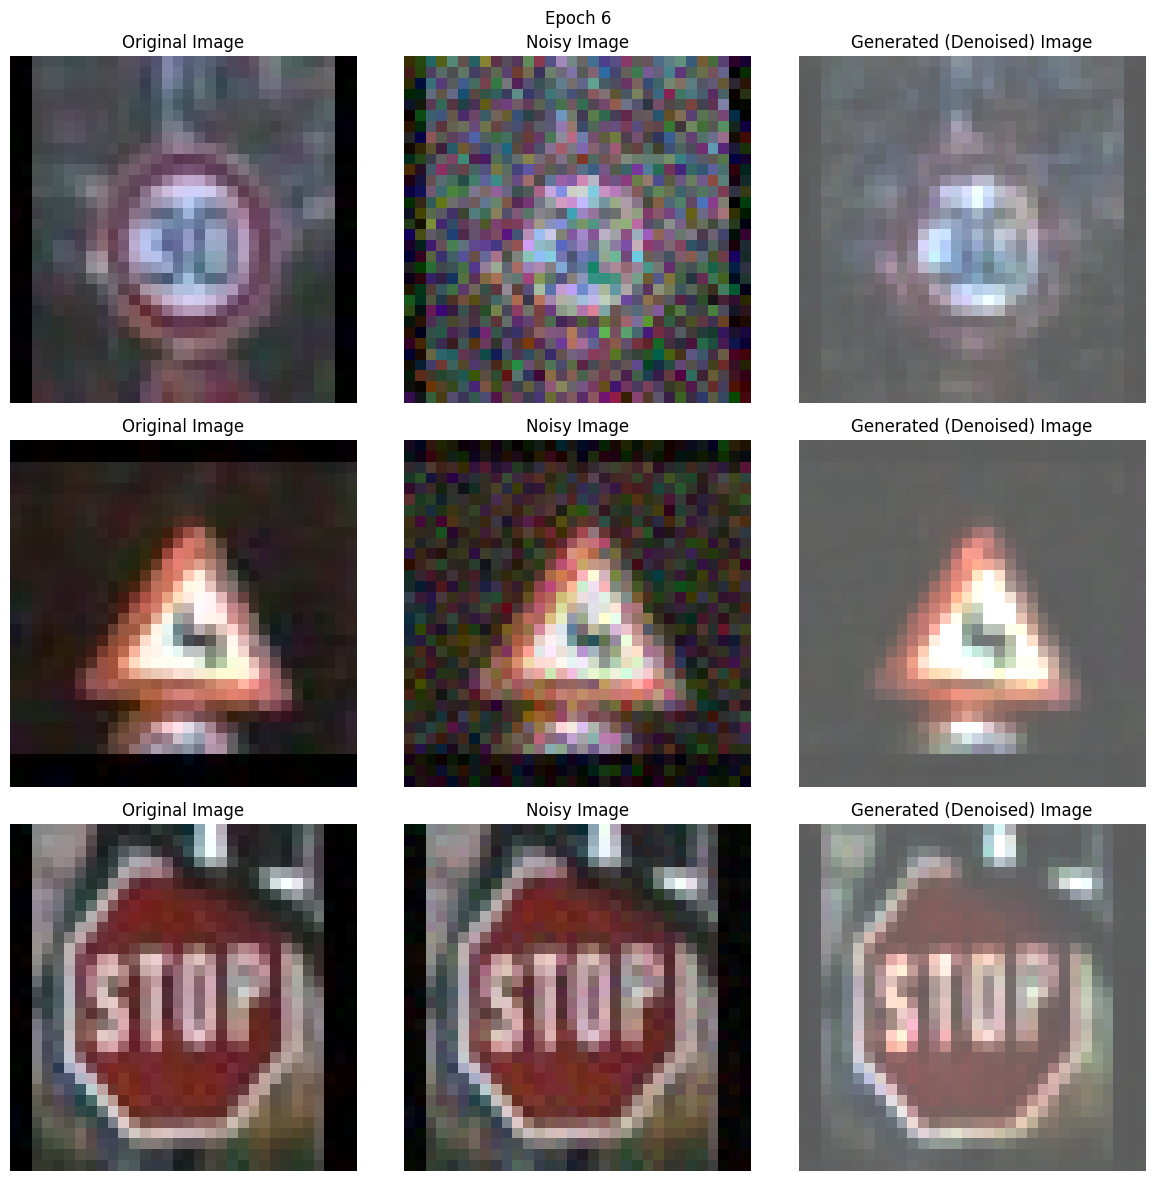

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.45it/s]


Finished epoch 7. Average loss for this epoch: 0.179885
Sample 1:
Tensor min: -1.0000, max: 0.3098
Tensor min: -1.0000, max: 0.7664
Tensor min: -0.2763, max: 0.5826
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2784, max: 1.3515
Sample 3:
Tensor min: -1.0000, max: 0.5765
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2784, max: 0.6446


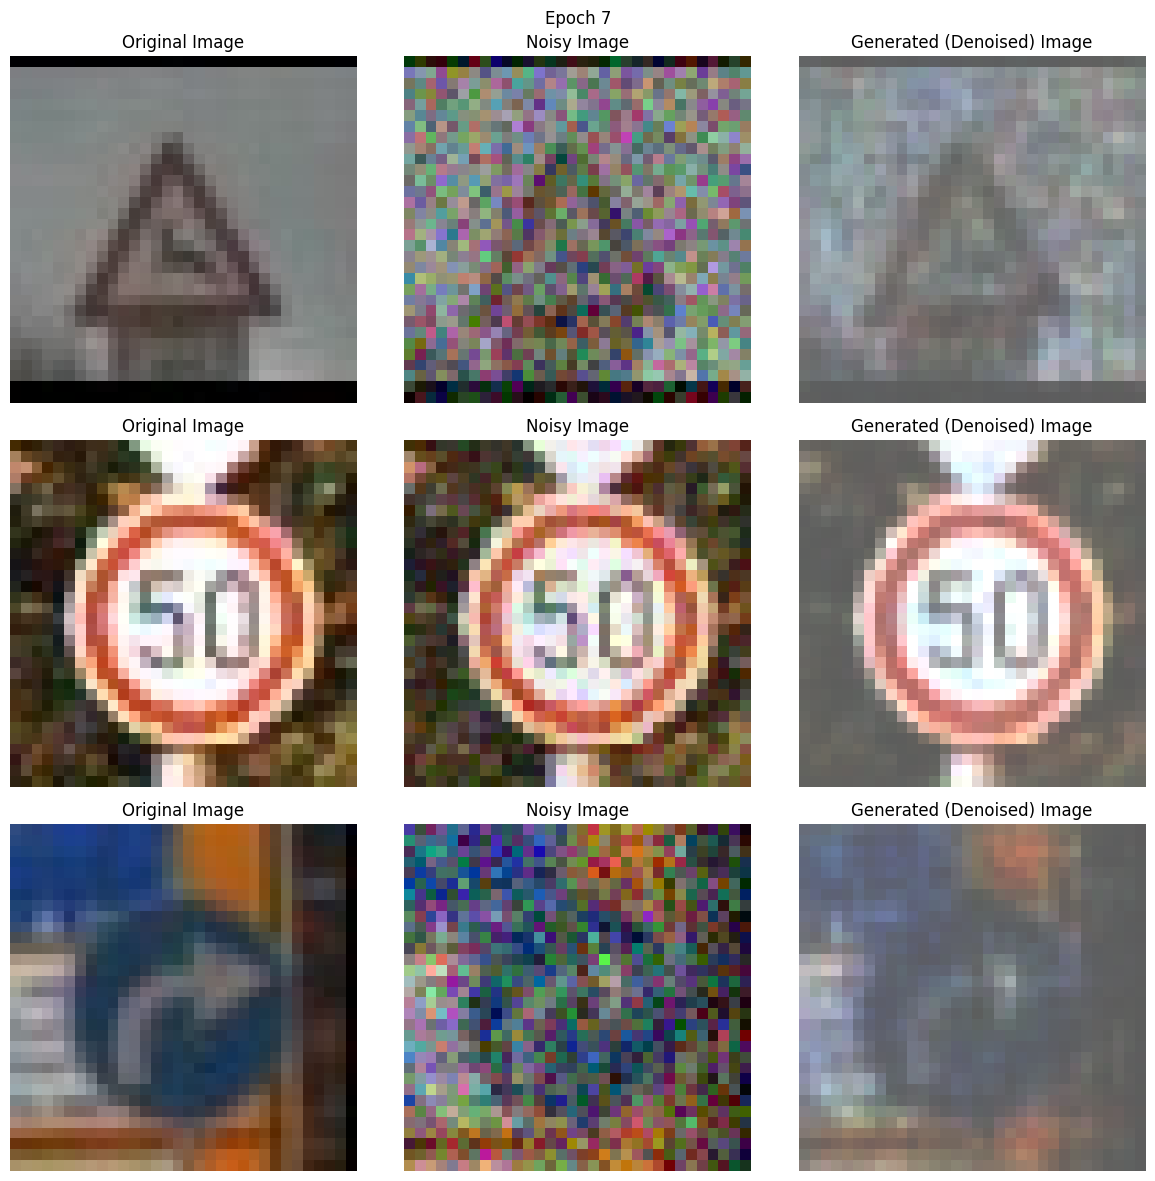

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.32it/s]


Finished epoch 8. Average loss for this epoch: 0.174013
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2772, max: 1.3712
Sample 2:
Tensor min: -0.9529, max: 0.2392
Tensor min: -0.9641, max: 0.2848
Tensor min: -0.2759, max: 0.2923
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.3435


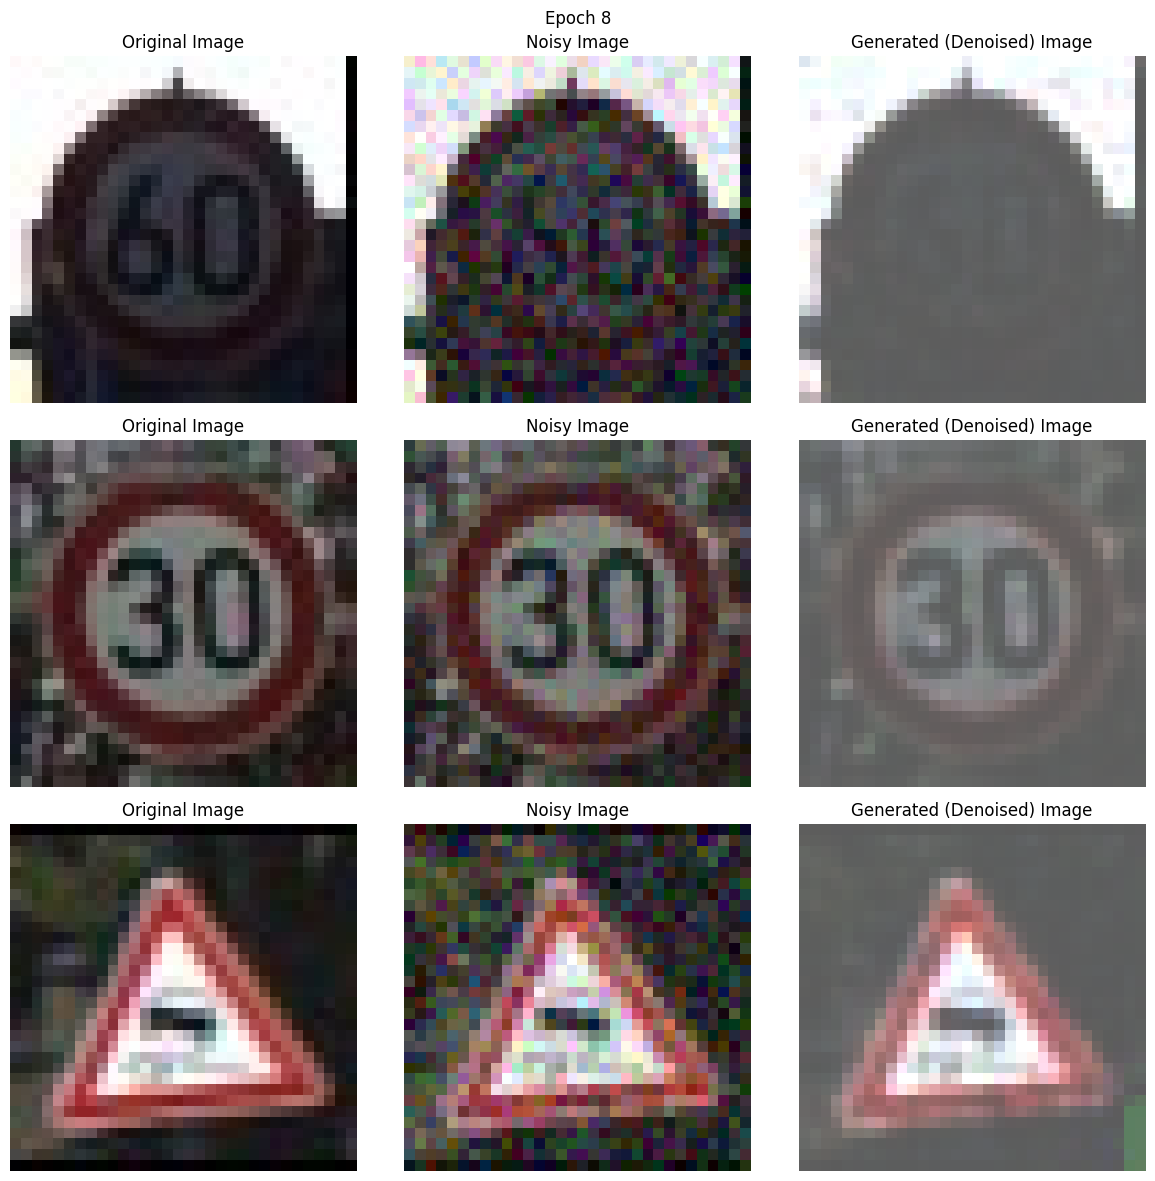

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:24<00:00, 22.62it/s]


Finished epoch 9. Average loss for this epoch: 0.169521
Sample 1:
Tensor min: -1.0000, max: 0.0275
Tensor min: -1.0000, max: 0.1036
Tensor min: -0.2743, max: 0.1435
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2784, max: 1.3590
Sample 3:
Tensor min: -1.0000, max: 0.6392
Tensor min: -1.0000, max: 0.6398
Tensor min: -0.2738, max: 0.7248


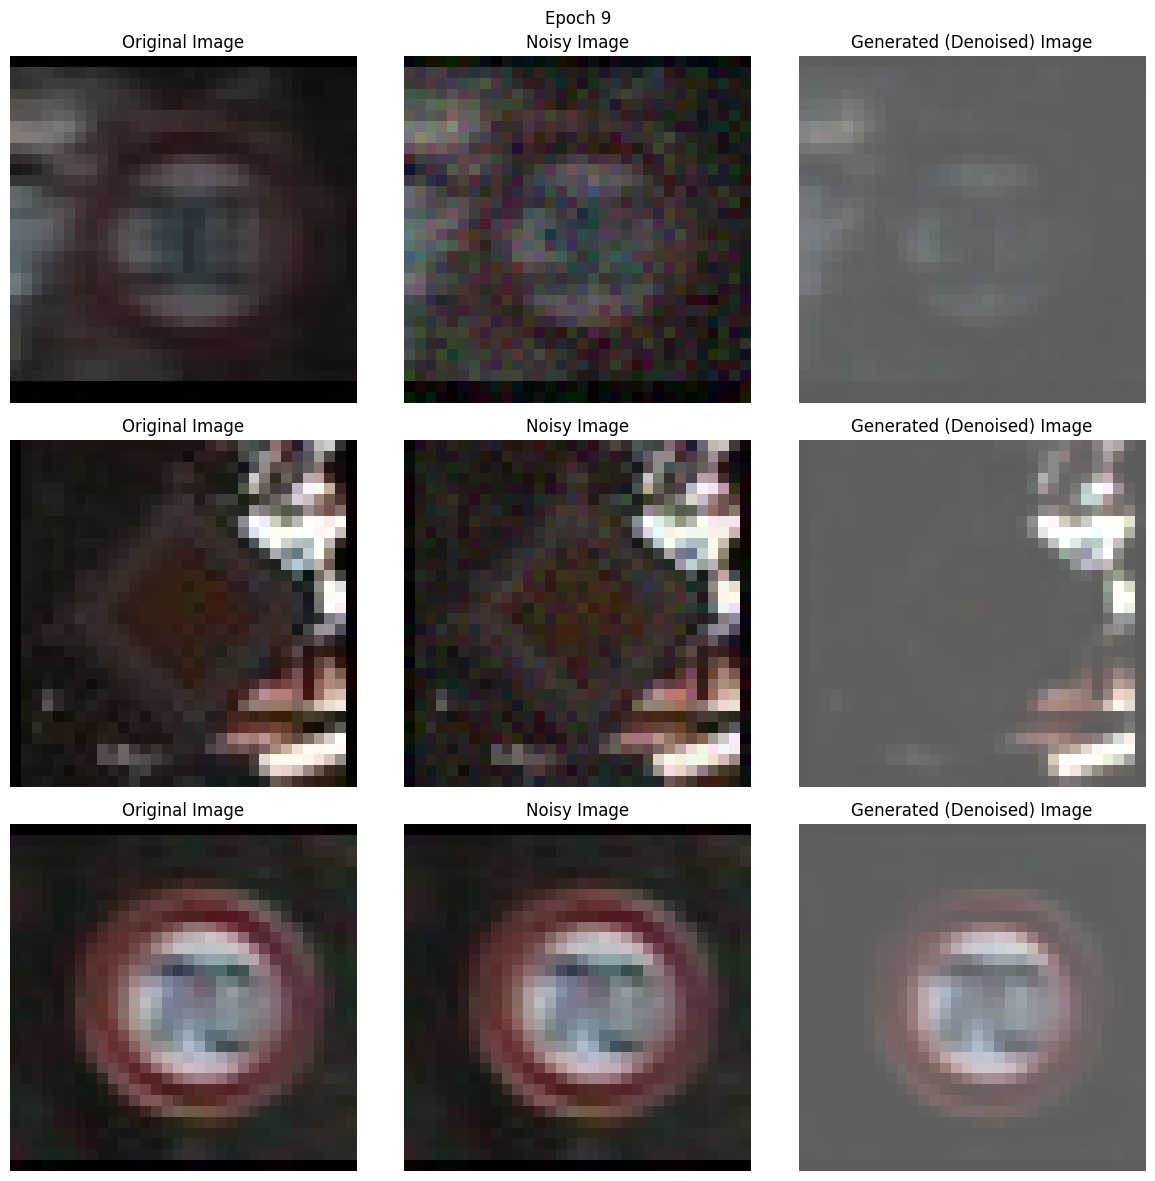

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.17it/s]


Finished epoch 10. Average loss for this epoch: 0.165182
Sample 1:
Tensor min: -1.0000, max: -0.1529
Tensor min: -1.0000, max: 0.5882
Tensor min: -0.2785, max: -0.1112
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.3787
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.4084


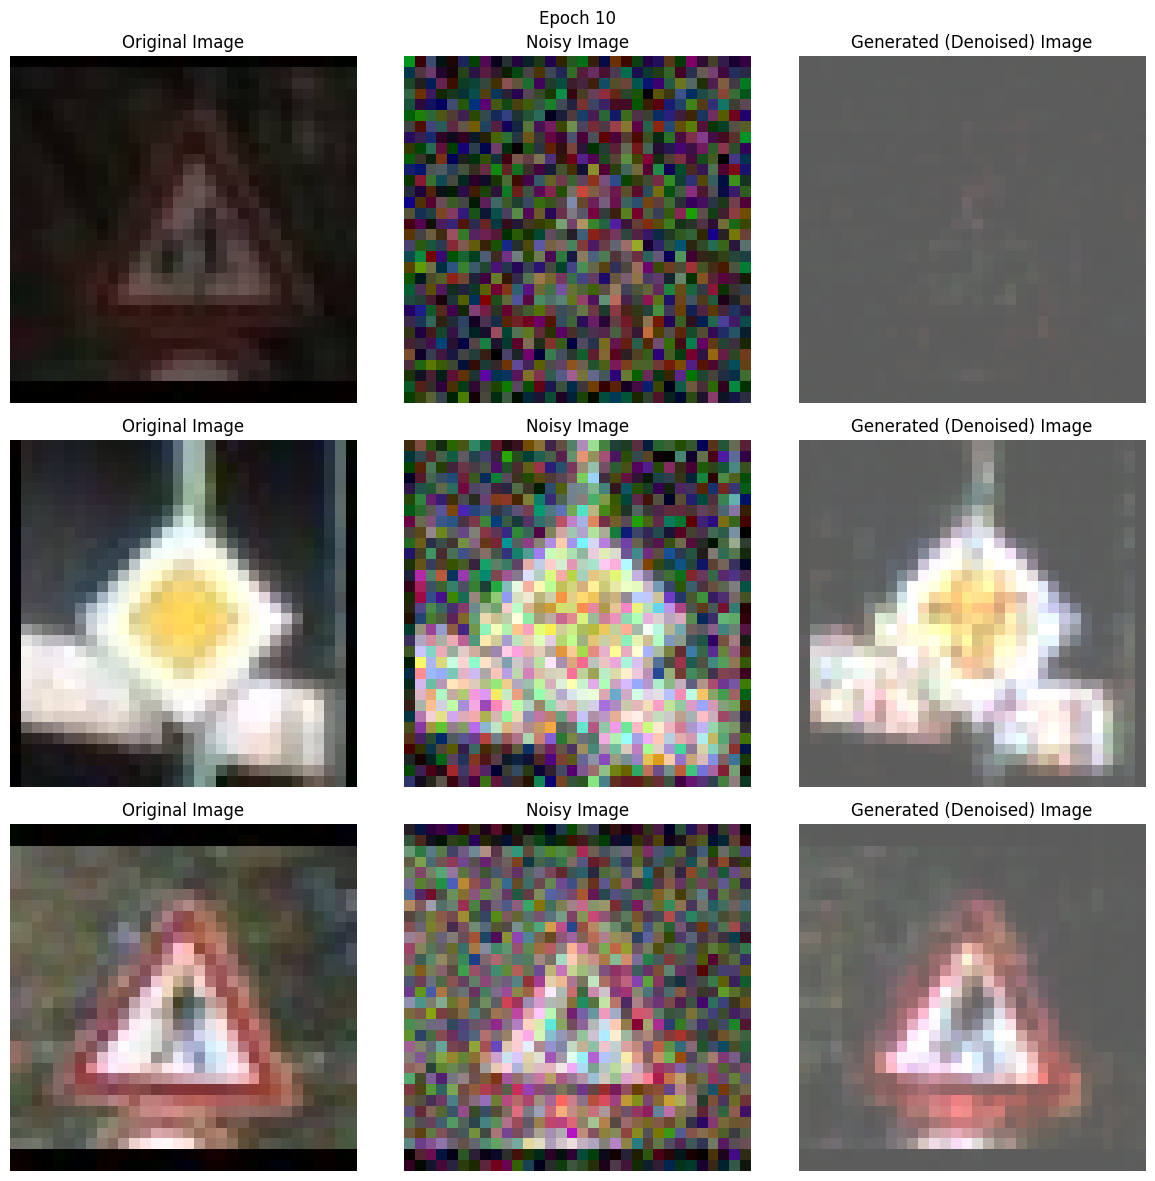

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.36it/s]


Finished epoch 11. Average loss for this epoch: 0.161728
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.1934
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.1101
Sample 3:
Tensor min: -1.0000, max: 0.3647
Tensor min: -1.0000, max: 0.7073
Tensor min: -0.2785, max: 0.5256


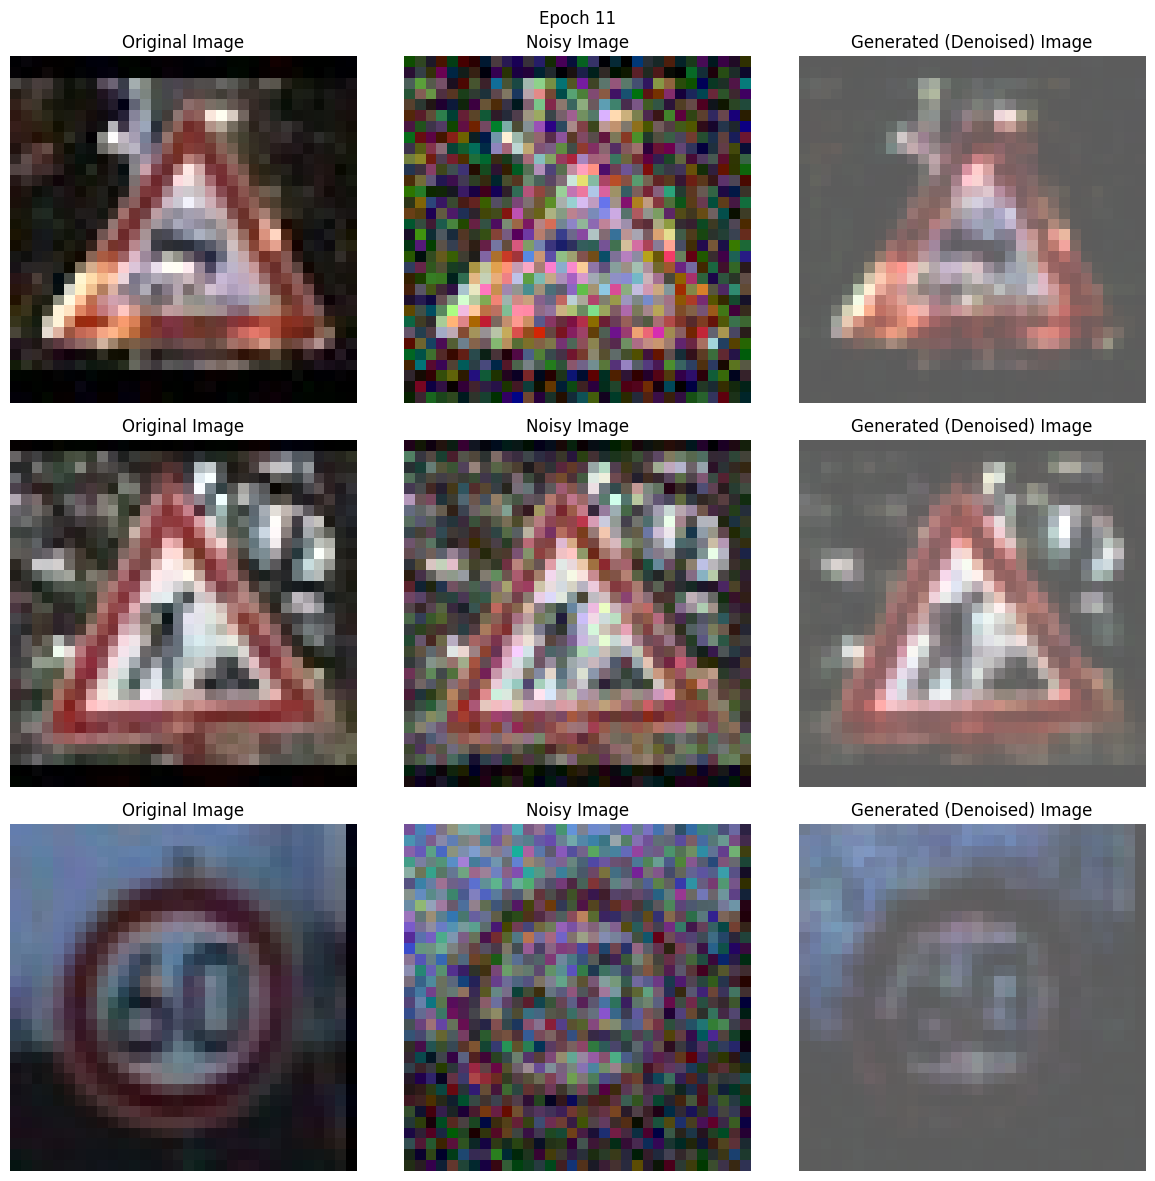

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:24<00:00, 22.51it/s]


Finished epoch 12. Average loss for this epoch: 0.158822
Sample 1:
Tensor min: -1.0000, max: -0.0667
Tensor min: -1.0000, max: 0.6568
Tensor min: -0.2785, max: 0.0864
Sample 2:
Tensor min: -1.0000, max: 0.1137
Tensor min: -1.0000, max: 0.1169
Tensor min: -0.2785, max: -0.0850
Sample 3:
Tensor min: -1.0000, max: 0.8039
Tensor min: -1.0000, max: 0.7708
Tensor min: -0.2785, max: 0.8051


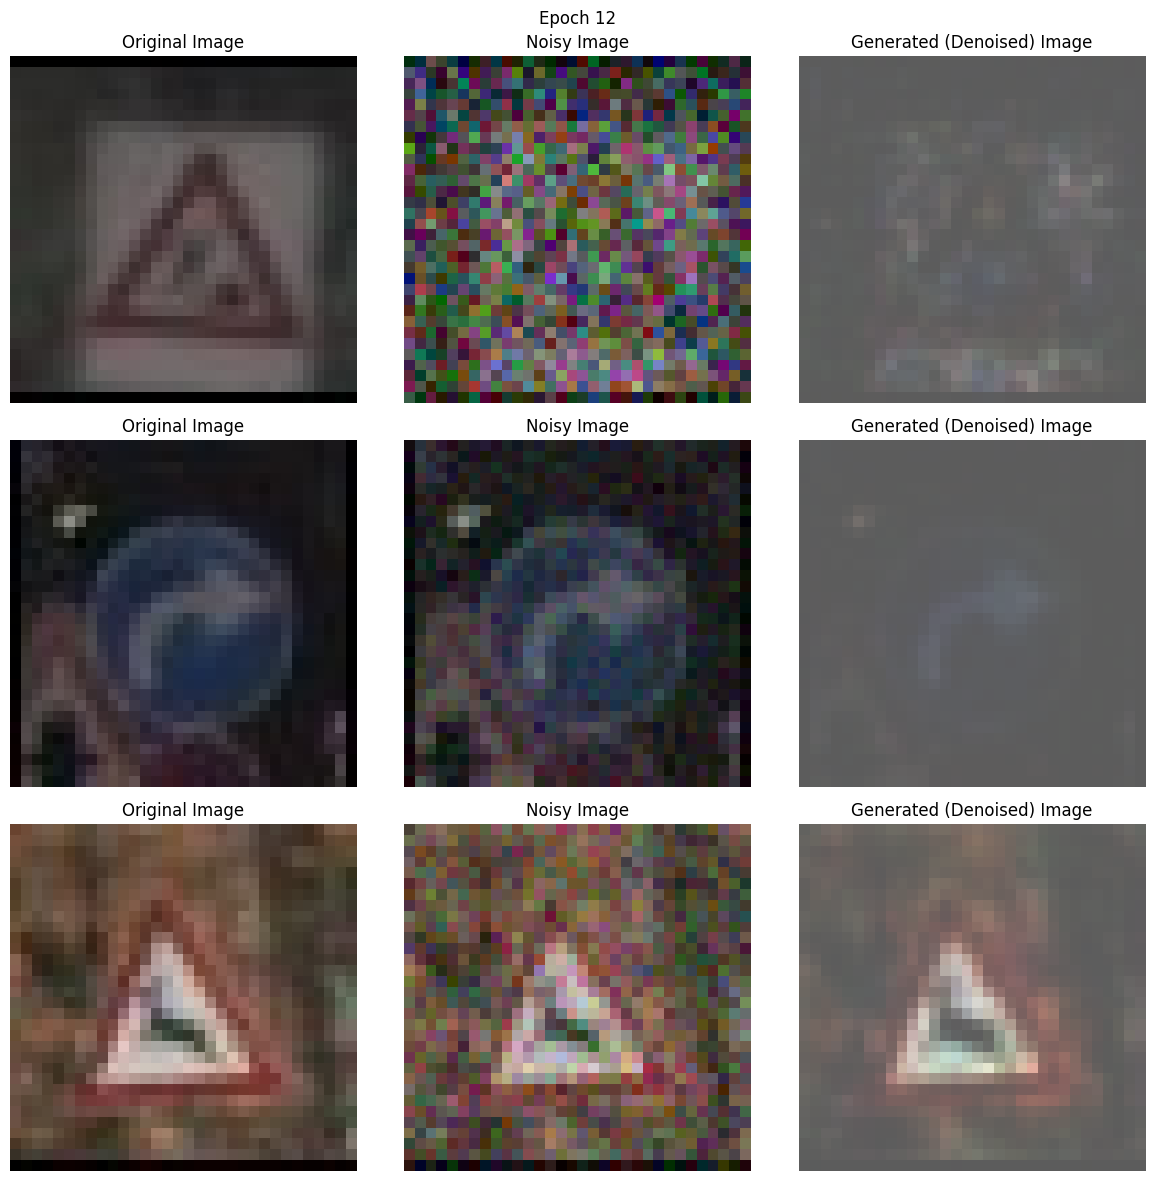

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:24<00:00, 22.24it/s]


Finished epoch 13. Average loss for this epoch: 0.156793
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.5324
Sample 2:
Tensor min: -1.0000, max: 0.1765
Tensor min: -1.0000, max: 0.5049
Tensor min: -0.2785, max: 0.3346
Sample 3:
Tensor min: -1.0000, max: 0.6863
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 0.9791


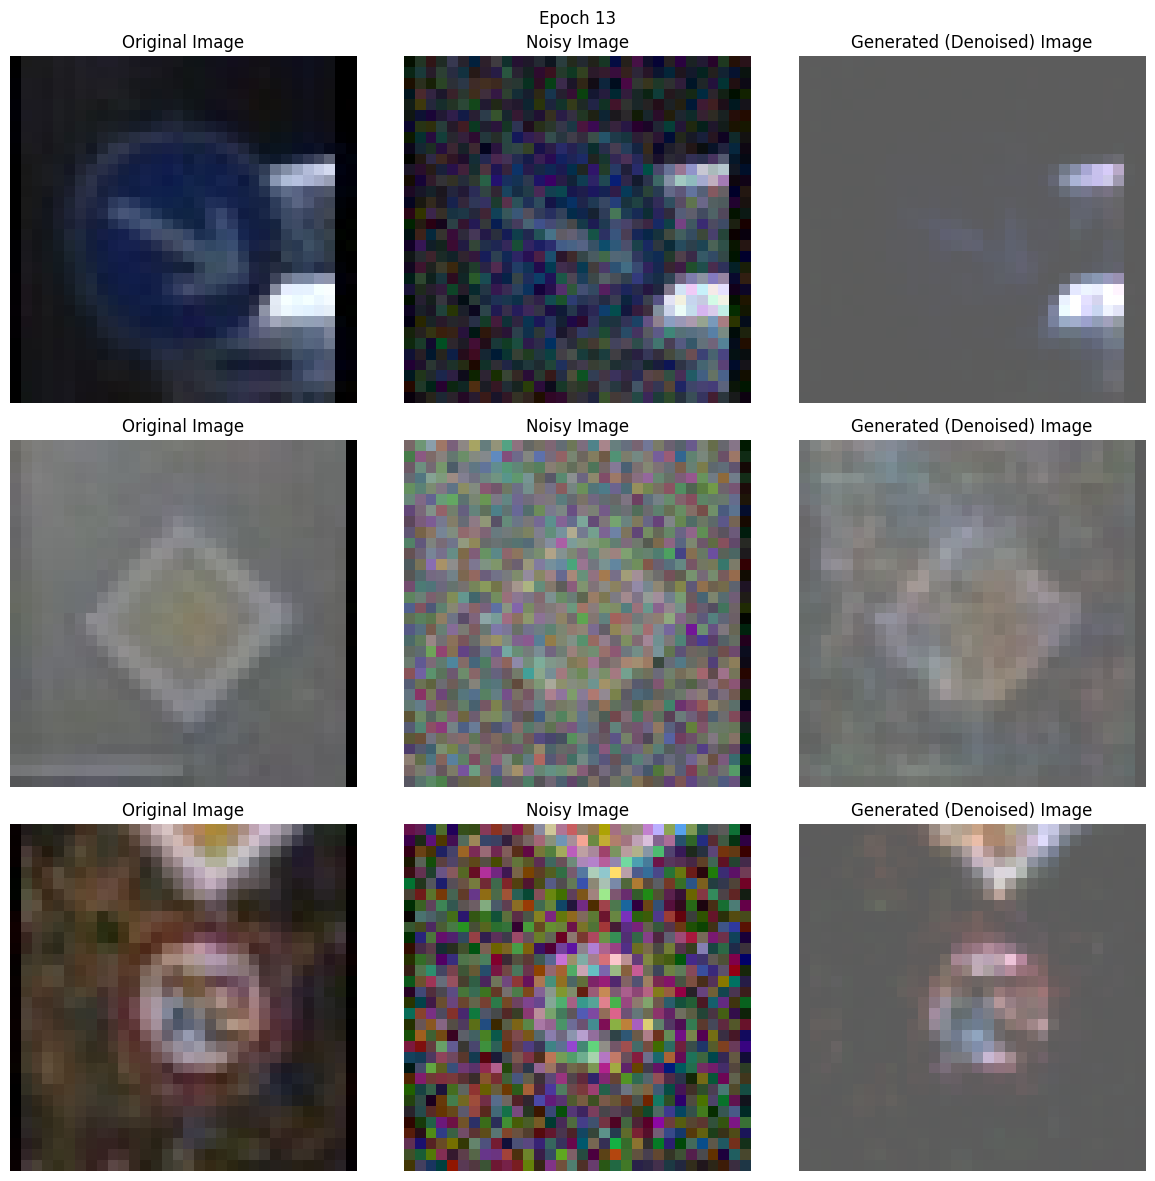

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:25<00:00, 21.88it/s]


Finished epoch 14. Average loss for this epoch: 0.155003
Sample 1:
Tensor min: -1.0000, max: 0.6157
Tensor min: -1.0000, max: 0.8202
Tensor min: -0.2785, max: 0.6592
Sample 2:
Tensor min: -1.0000, max: 0.1843
Tensor min: -1.0000, max: 0.4080
Tensor min: -0.2785, max: -0.0618
Sample 3:
Tensor min: -1.0000, max: 0.7255
Tensor min: -1.0000, max: 0.6287
Tensor min: -0.2785, max: 0.0719


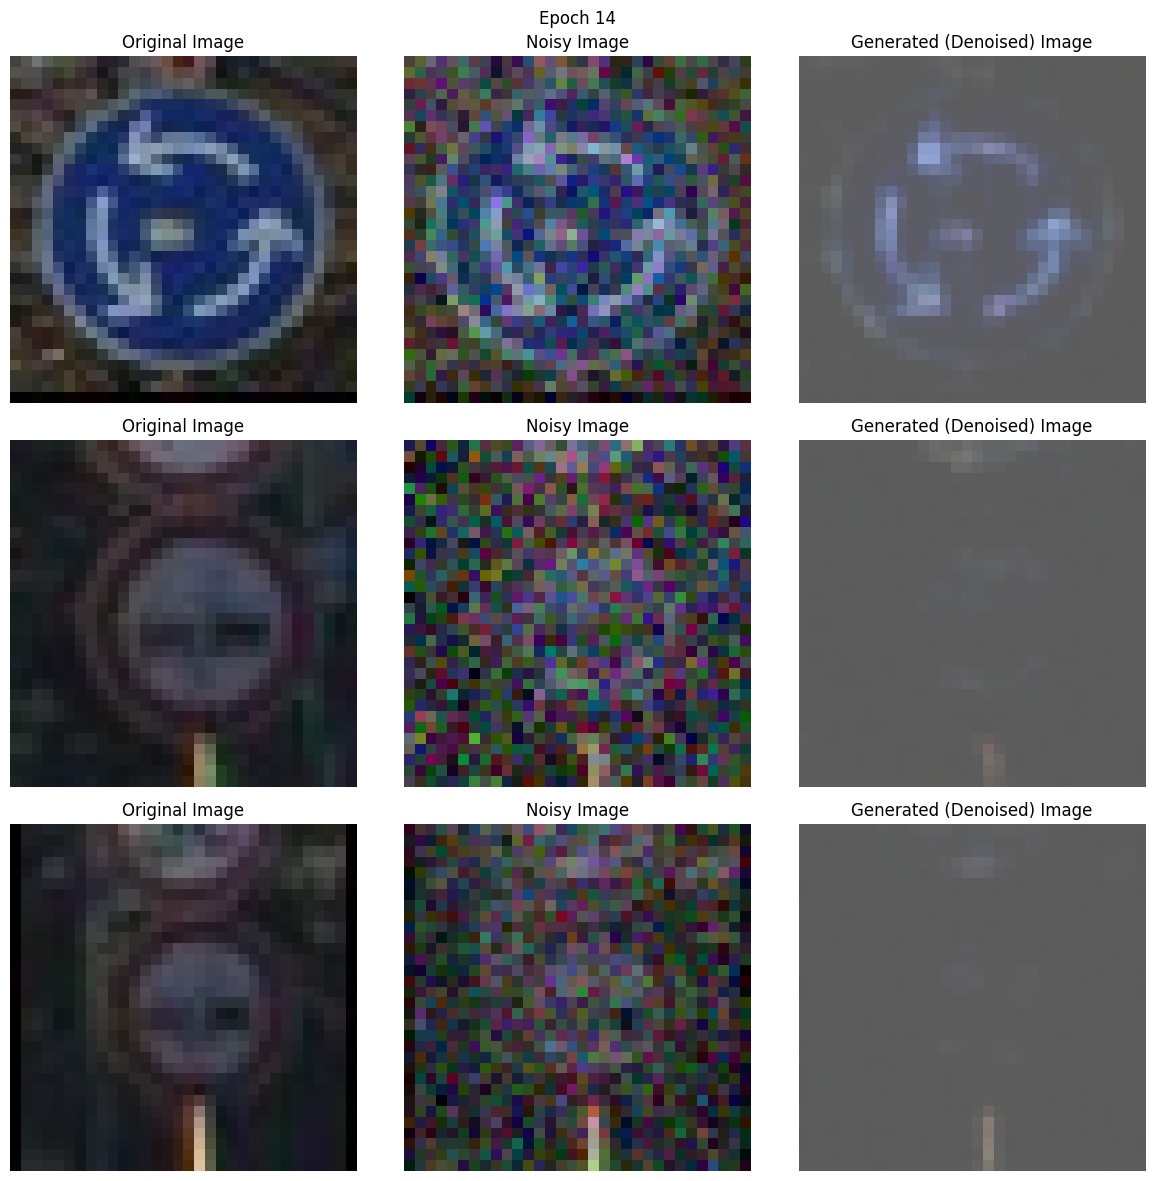

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.14it/s]


Finished epoch 15. Average loss for this epoch: 0.153907
Sample 1:
Tensor min: -0.9216, max: -0.4431
Tensor min: -1.0000, max: -0.0255
Tensor min: -0.2785, max: -0.1838
Sample 2:
Tensor min: -1.0000, max: -0.3882
Tensor min: -1.0000, max: -0.3230
Tensor min: -0.2780, max: -0.2032
Sample 3:
Tensor min: -1.0000, max: 0.1451
Tensor min: -1.0000, max: 0.6911
Tensor min: -0.2785, max: 0.5473


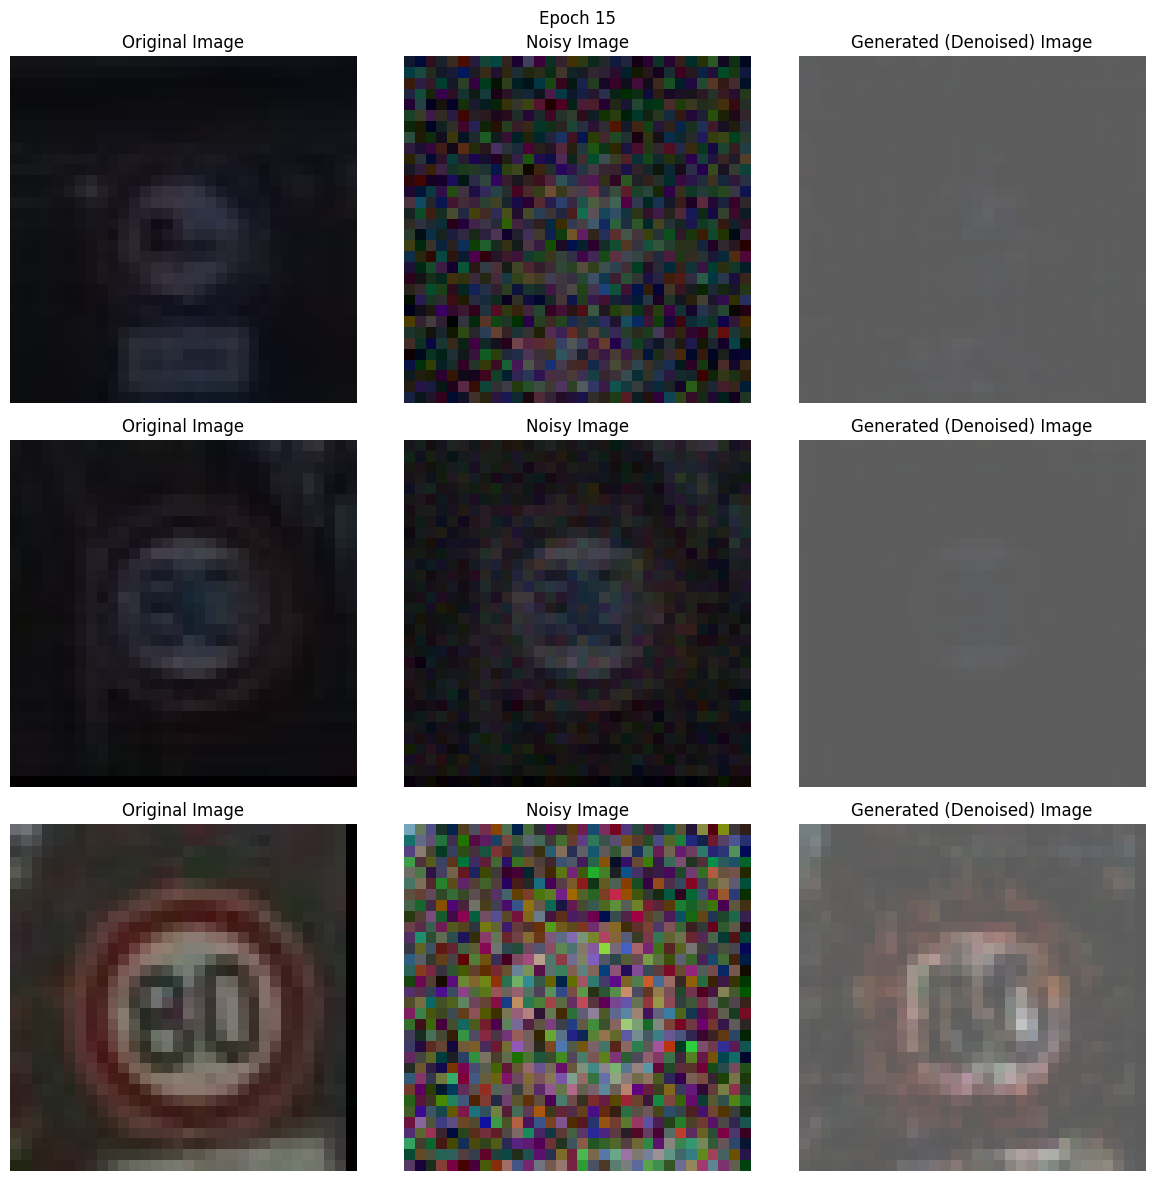

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.50it/s]


Finished epoch 16. Average loss for this epoch: 0.152668
Sample 1:
Tensor min: -0.9294, max: 1.0000
Tensor min: -0.9735, max: 1.0000
Tensor min: -0.2785, max: 0.9316
Sample 2:
Tensor min: -0.9294, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 0.9356
Sample 3:
Tensor min: -1.0000, max: 0.1373
Tensor min: -1.0000, max: 0.1882
Tensor min: -0.2785, max: -0.2149


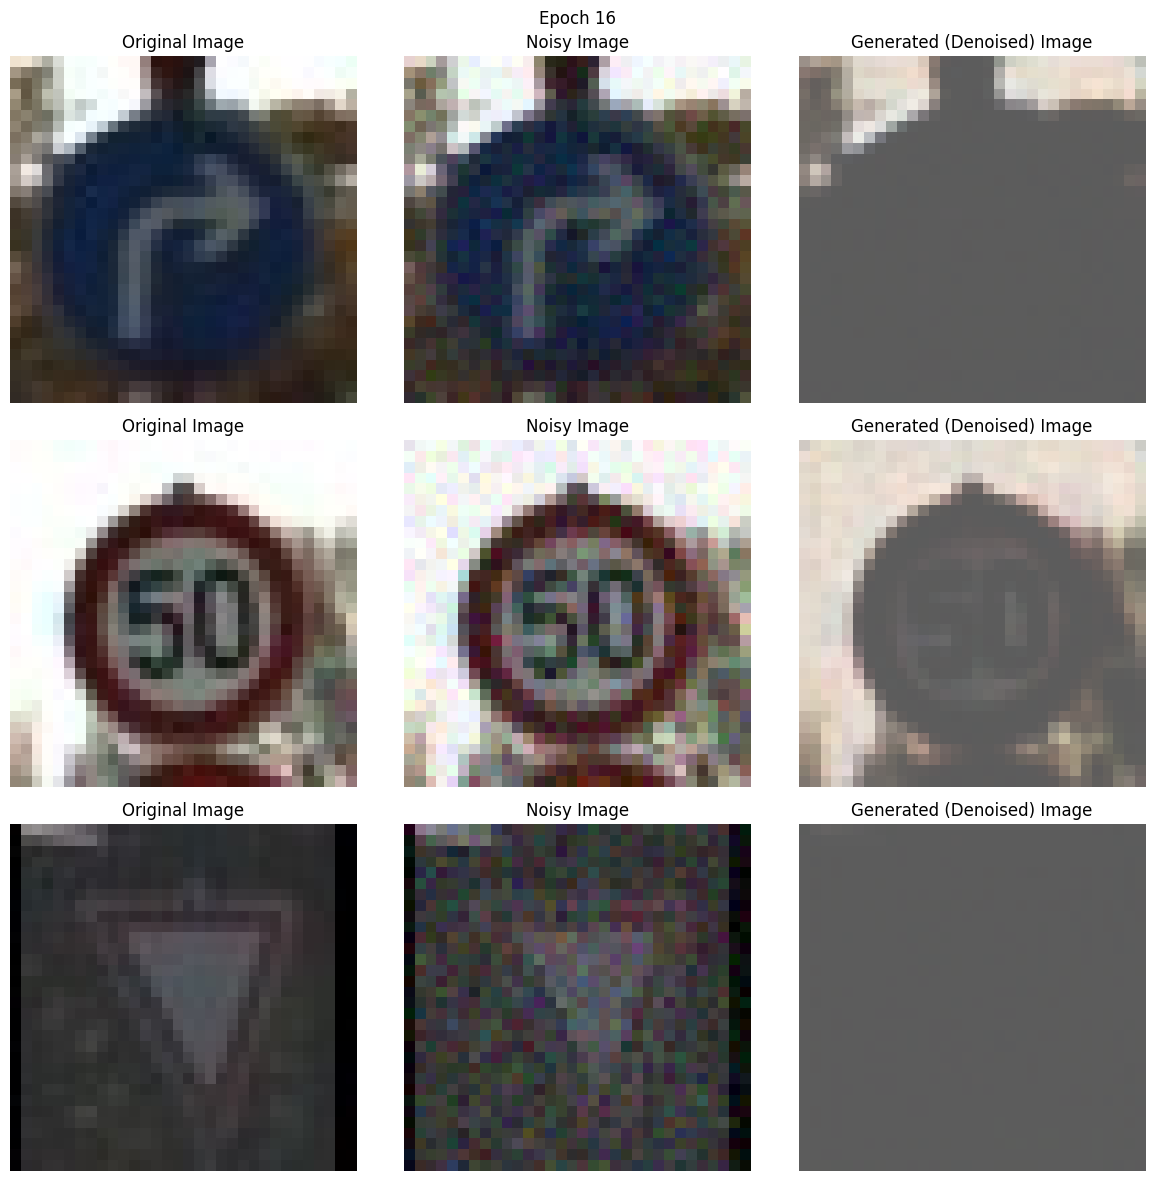

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.35it/s]


Finished epoch 17. Average loss for this epoch: 0.152191
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.8189
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.2054
Sample 3:
Tensor min: -1.0000, max: 0.0667
Tensor min: -1.0000, max: 0.1788
Tensor min: -0.2785, max: 0.2924


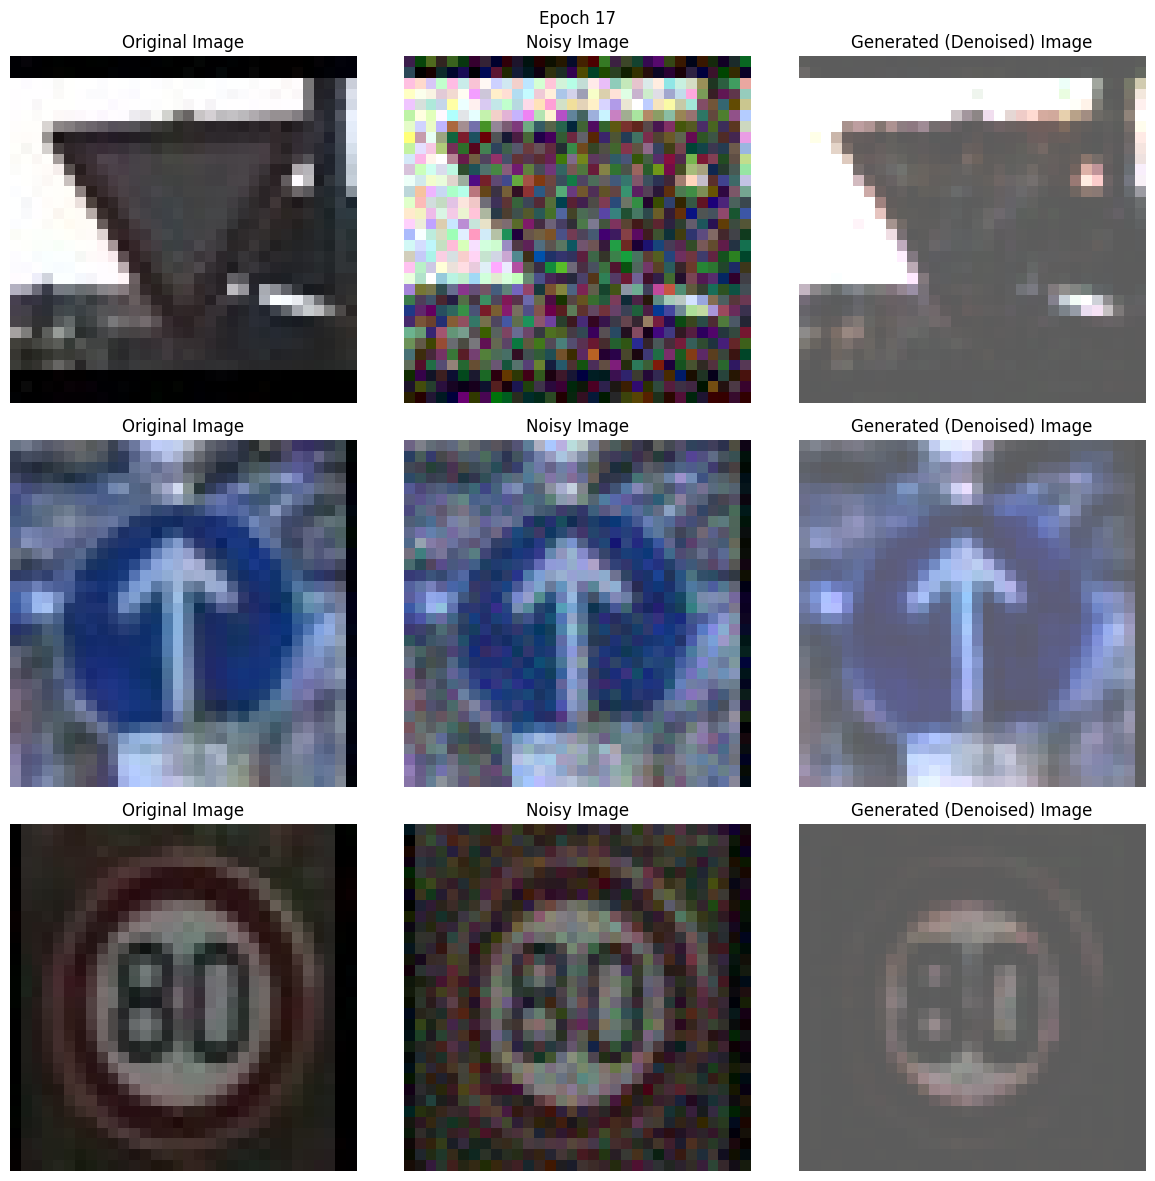

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.28it/s]


Finished epoch 18. Average loss for this epoch: 0.151459
Sample 1:
Tensor min: -1.0000, max: 0.9529
Tensor min: -1.0000, max: 0.9298
Tensor min: -0.2785, max: 1.0279
Sample 2:
Tensor min: -1.0000, max: 0.3725
Tensor min: -1.0000, max: 0.5666
Tensor min: -0.2785, max: 0.5067
Sample 3:
Tensor min: -1.0000, max: 0.0039
Tensor min: -1.0000, max: 0.7786
Tensor min: -0.2785, max: -0.0752


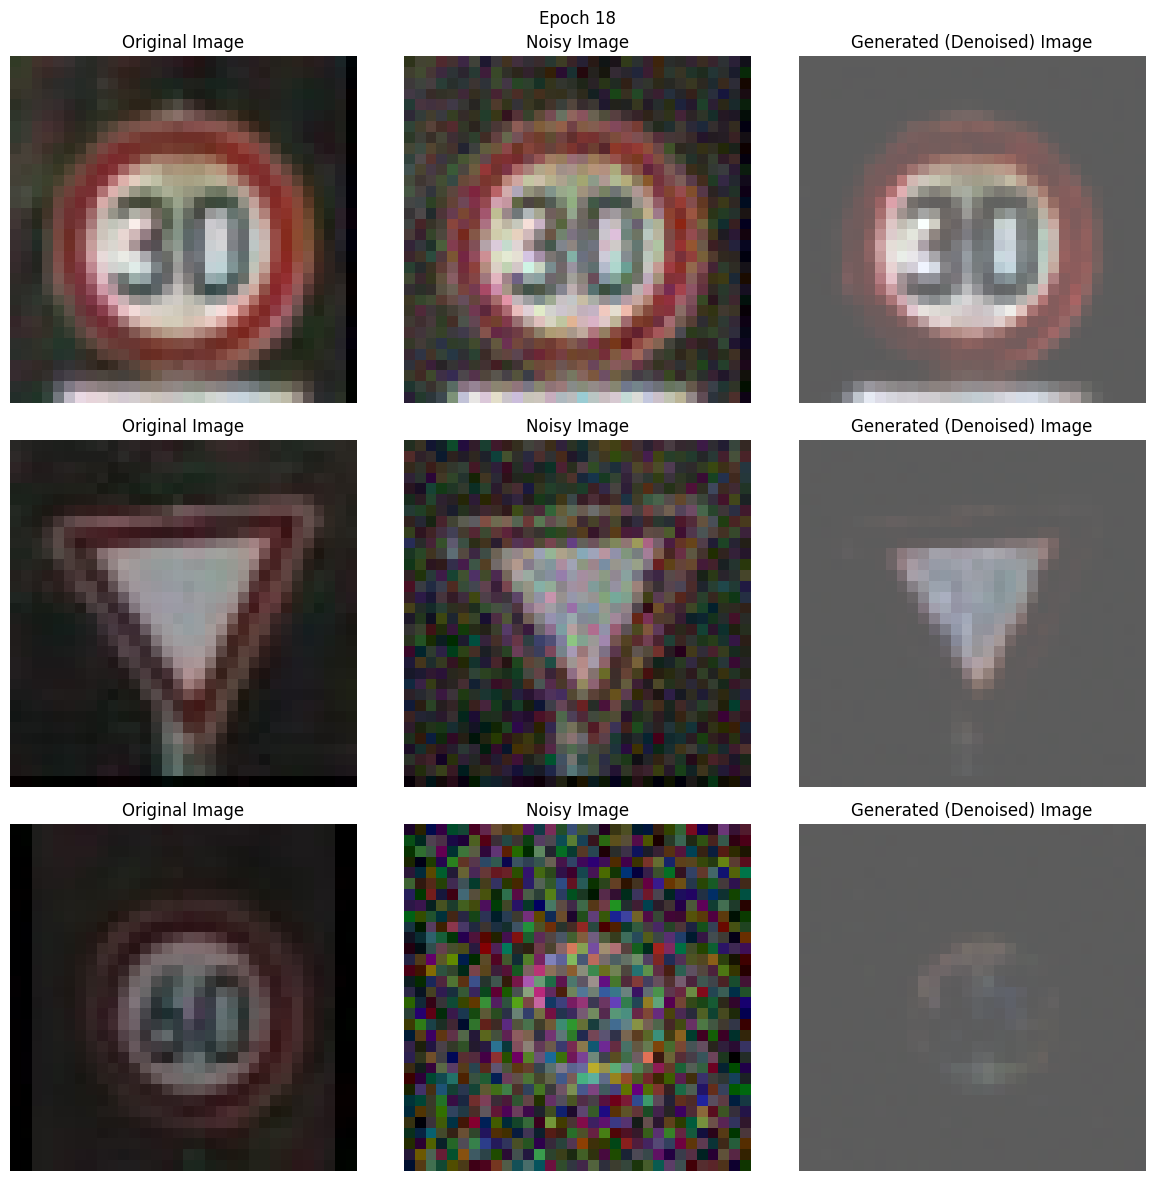

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.79it/s]


Finished epoch 19. Average loss for this epoch: 0.151197
Sample 1:
Tensor min: -1.0000, max: 0.2078
Tensor min: -1.0000, max: 0.4879
Tensor min: -0.2785, max: 0.3249
Sample 2:
Tensor min: -1.0000, max: -0.1608
Tensor min: -1.0000, max: 0.3336
Tensor min: -0.2785, max: -0.0012
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2785, max: 1.2389


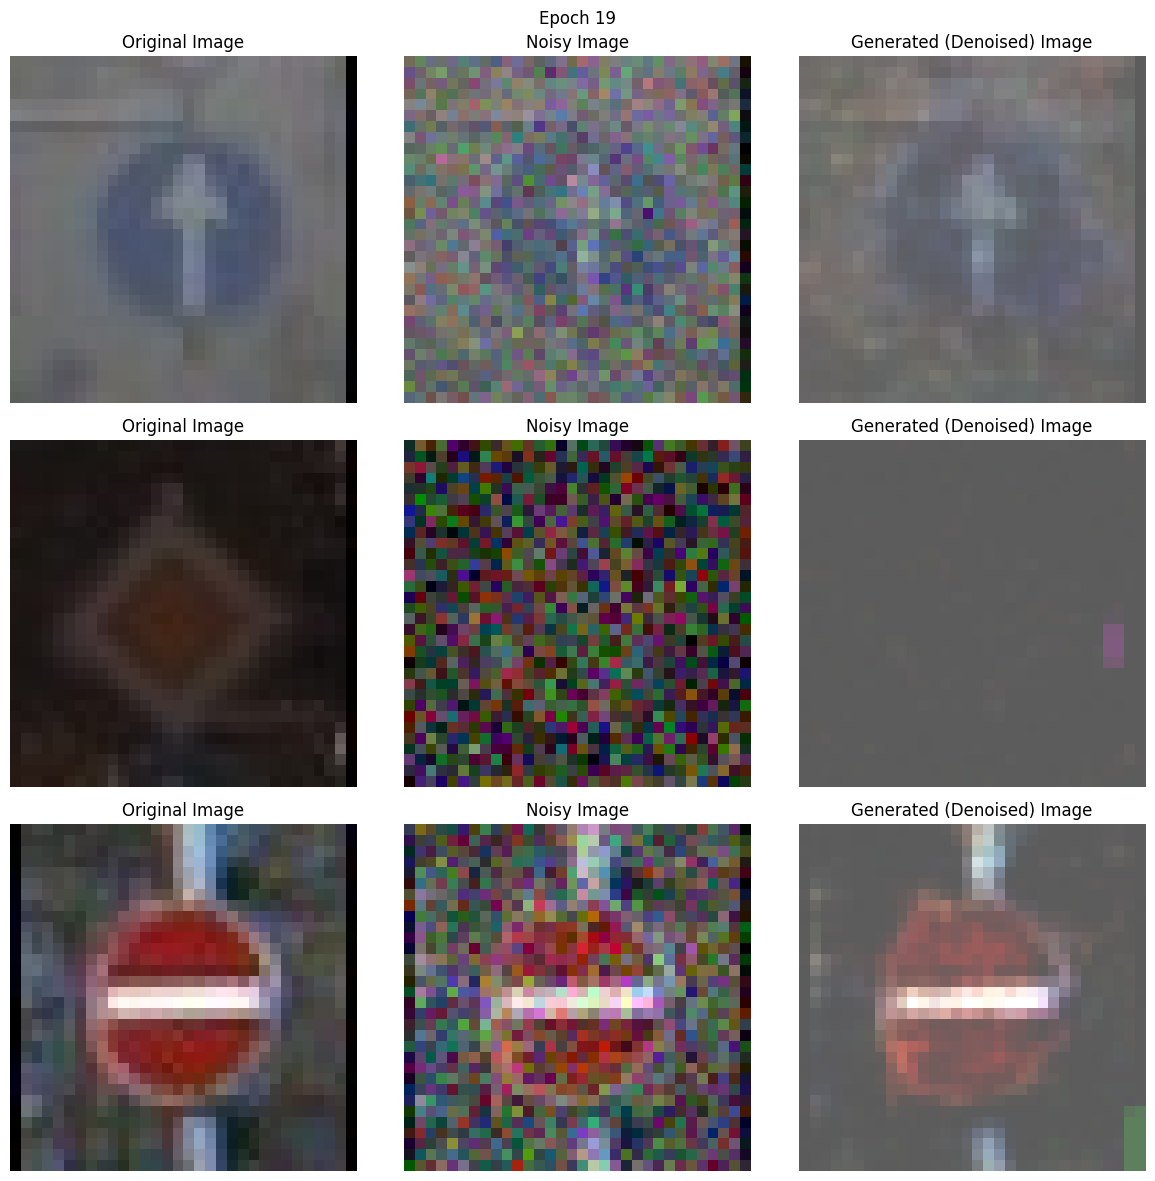

In [17]:
n_epochs = 20

net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-4)

losses = []

for epoch in range(n_epochs):

    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) * 0.3
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, y, noise_amount)

        loss = loss_fn(pred, x)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

    with torch.no_grad():
        num_samples = min(3, x.shape[0])  # Visualize up to 3 images
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
        if num_samples == 1:
            axes = [axes]  # Make axes iterable for single sample

        for i in range(num_samples):
            original = x[i]  # Original image
            noisy = noisy_x[i]  # Noisy image
            generated = pred[i]  # Model's denoised output

            # Convert tensors to images
            print(f"Sample {i+1}:")
            original_img = tensor_to_image(original, normalize=True)
            noisy_img = tensor_to_image(noisy, normalize=True)
            generated_img = tensor_to_image(generated, normalize=True)

            # Plot original
            axes[i][0].imshow(original_img)
            axes[i][0].set_title('Original Image')
            axes[i][0].axis('off')

            # Plot noisy
            axes[i][1].imshow(noisy_img)
            axes[i][1].set_title('Noisy Image')
            axes[i][1].axis('off')

            # Plot generated
            axes[i][2].imshow(generated_img)
            axes[i][2].set_title('Generated (Denoised) Image')
            axes[i][2].axis('off')

        plt.suptitle(f'Epoch {epoch}')
        plt.tight_layout()
        plt.show()

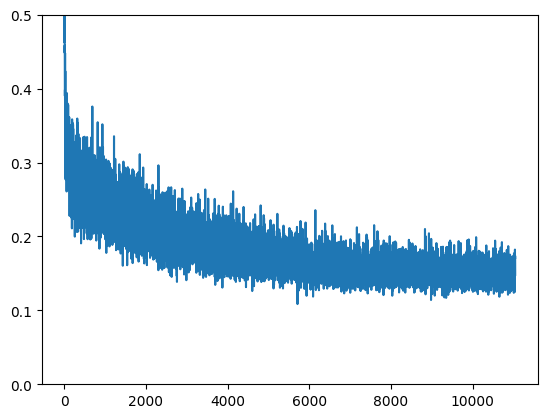

In [18]:
plt.plot(losses)
plt.ylim(0, 0.5);

In [19]:
import torch
import torchvision.transforms as T
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm

# Inicjalizacja FID
fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)

# Resize do 299x299 i normalizacja do [-1, 1] → wymagane przez Inception
transform = T.Compose([
    T.Resize((299, 299)),
    T.Normalize((0.5,), (0.5,)) if x.shape[1] == 1 else T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Zbieranie obrazów z walidacji lub testu
net.eval()
with torch.no_grad():
    for x, y in tqdm(val_loader):  # Upewnij się, że val_loader jest zdefiniowany
        x = x.to(device)
        y = y.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) * 0.3
        noisy_x = corrupt(x, noise_amount)
        pred = net(noisy_x, y, noise_amount)

        for real_img, gen_img in zip(x, pred):
            real_img = transform(real_img).unsqueeze(0)
            gen_img = transform(gen_img).unsqueeze(0)
            fid.update(real_img, real=True)
            fid.update(gen_img, real=False)

fid_score = fid.compute()
print(f"FID score: {fid_score.item():.4f}")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [01:48<00:00,  1.76s/it]


FID score: 82.6703


In [20]:
torch.save(net.state_dict(), 'unet-82-fid.pth')